In [102]:
import os

os.environ["OMP_NUM_THREADS"] = "6" # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = "6" # export OPENBLAS_NUM_THREADS=4
os.environ["MKL_NUM_THREADS"] = "6" # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "6" # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "6" # export NUMEXPR_NUM_THREADS=6

import sys
import copy
from tqdm  import tqdm

import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms

from dataset import NO2PredictionDataset
from transforms import ChangeBandOrder, ToTensor, DatasetStatistics, Normalize, Randomize
from model import get_model
from utils import load_data, set_seed, step, read_param_file
from train_utils import eval_metrics, split_samples, train, test
from shapely import wkt

import rasterio as rio
from rasterio.plot import reshape_as_image
from rasterio.enums import Resampling
from rasterio.errors import RasterioIOError
import matplotlib.pyplot as plt

from importlib import import_module

import xarray as xr
import shapely
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch

from transforms import ChangeBandOrder, ToTensor, DatasetStatistics, Normalize, Randomize

In [2]:
def normalized_rgb(img):
    high_p = np.percentile(img, 98, axis=(0,1))
    low_p = np.percentile(img, 2, axis=(0,1))
    
    norm = (img - low_p) / (high_p - low_p)
    
    return norm[:, :, [0,1,2]]
    
def show(img):
    norm = normalized_rgb(img)
    fig, ax = plt.subplots(1, figsize=(8,8))
    ax.imshow(norm)
    for i in range(1, norm.shape[0]//120):
        ax.vlines(i*120, 0, 1199, color="red")
        ax.hlines(i*120, 0, 1199, color="red")
    ax.axis(False)
    plt.show()
    
def get_buffer(gdf, edge_length):
    """return a buffer around the geometry column of `gdf`
    the buffer is a rectangle of `edge_length` in meters
    """
    geodata = gdf.to_crs("EPSG:3035") # equal area projection in meters for Europe
    buffer_size = edge_length / 2 # gdf.buffer takes distance from geometry

    buffer = geodata.buffer(buffer_size, cap_style=3).to_crs(gdf.crs)
    return buffer

def get_s5p_at_station(s5p_data, station_location, out_size=120):
    """
    (1) create a buffer of 10x10km around station location
    (2) clip s5p_data according to that buffer
    (3) interpolate s5p_data to 100x100 pixel
    (4) create a buffer of 1.2x1.2km around station location
    (5) clip s5p_data according to that buffer (corresponds to 120x120 Sentinel-2 pixel)
    (6) interpolate remaining s5p_data to 120x120 pixel
    (7) fill NA's at the borders
    note: we can't just take the 1.2x1.2km buffer directly because rioxarray.clip will
    not return data if resolution > geometry of interest
    """
    assert isinstance(station_location, gpd.GeoDataFrame), "input has to be a Geopandas GeoDataFrame"

    area = get_buffer(station_location, 30000) # (1)
    area = shapely.geometry.mapping(area.item()) # create correct geom representation for rioxarray.clip
    clipped_s5p_data = s5p_data.rio.clip([area], s5p_data.rio.crs) # (2)

        # (3)
    clipped_s5p_data_interp = clipped_s5p_data.interp(longitude=np.linspace(clipped_s5p_data.longitude.min().item(),
                                                                                clipped_s5p_data.longitude.max().item(),
                                                                                1000),
                                                          latitude=np.linspace(clipped_s5p_data.latitude.min().item(),
                                                                               clipped_s5p_data.latitude.max().item(),
                                                                               1000))
    area = get_buffer(station_location, out_size*10) # (4)
    area = shapely.geometry.mapping(area.item())
    clipped_s5p_data = clipped_s5p_data_interp.rio.clip([area], clipped_s5p_data_interp.rio.crs) # (5)

        # (6)
    clipped_s5p_data_interp = clipped_s5p_data.interp(longitude=np.linspace(clipped_s5p_data.longitude.min().item(),
                                                                                clipped_s5p_data.longitude.max().item(),
                                                                                out_size),
                                                          latitude=np.linspace(clipped_s5p_data.latitude.min().item(),
                                                                               clipped_s5p_data.latitude.max().item(),
                                                                               out_size))
    output = clipped_s5p_data_interp.interpolate_na(dim="longitude", fill_value="extrapolate").interpolate_na(dim="latitude", fill_value="extrapolate")
    return output

In [3]:
# load trained dropout model from saved mlflow run 
run = "mlruns/74/b8af3d3ee8ef476f8fdff7bc6c4400b1/" # heteroscedastic whole_timespan 0.05, 0.05 0.55 R2

samples_file = read_param_file(run + "params/samples_file")
datadir = read_param_file(run + "params/datadir")
verbose = True
sources = read_param_file(run + "params/sources")
frequency = read_param_file(run + "params/frequency")
heteroscedastic = bool(read_param_file(run + "params/heteroscedastic"))

dropout_config = {"p_second_to_last_layer" : float(read_param_file(run + "params/dropout_p_second_to_last_layer")),
                 "p_last_layer" : float(read_param_file(run + "params/dropout_p_last_layer")),
                 }

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_package = import_module(run.replace("/", ".") + "artifacts.model")

checkpoint = None #read_param_file(run + "params/pretrained_checkpoint")

In [4]:
# get original model
#run2 = "mlruns/21/4166c84b6ec149998a92459bbe715719/" # no dropout 0.6 r2
run2 = "mlruns/98/70d3b8e9a44e4f6bb2662b671d6c6014/" # no dropout 0.6 r2 same model structure as above

samples_file2 = read_param_file(run2 + "params/samples_file")
datadir2 = read_param_file(run2 + "params/datadir")
sources2 = read_param_file(run2 + "params/sources")
frequency2 = read_param_file(run2 + "params/frequency")
# heteroscedastic = bool(read_param_file(run + "params/heteroscedastic"))

dropout_config2 = {"p_second_to_last_layer" : float(read_param_file(run2 + "params/dropout_p_second_to_last_layer")),
                 "p_last_layer" : float(read_param_file(run2 + "params/dropout_p_last_layer")),
                 }

model_package2 = import_module(run2.replace("/", ".") + "artifacts.model")
checkpoint2 = None #read_param_file(run2 + "params/pretrained_checkpoint")

In [249]:
frequency = "2018_2020"
epa = True
eea = False

# use EPA dataset
if epa:
    datadir = "/netscratch/lscheibenreif/epa"
    samples_file = "data/samples_S2S5P_" + frequency + "_epa.csv"
elif eea:
    datadir = "/netscratch/lscheibenreif/eea"
    samples_file = "data/samples_S2S5P_" + frequency + ".csv"

In [250]:
# load dataset
if frequency == "2018_2020":
    frequency = "whole_timespan"
    
samples, stations = load_data_light_new(datadir, samples_file, frequency, sources)

100%|██████████| 91/91 [00:14<00:00,  6.08it/s]


In [251]:
#tf = transforms.Compose([ChangeBandOrder()])#, Normalize(datastats), Randomize(), ToTensor()])
# get dataset transforms
datastats = DatasetStatistics()
normalizer = Normalize(datastats)
tf = transforms.Compose([ChangeBandOrder(), normalizer])
dataset = NO2PredictionDataset(datadir, samples, frequency, sources, transforms=tf, station_imgs=stations)
dataloader = DataLoader(dataset, batch_size=1, num_workers=1, shuffle=False, pin_memory=False)

In [252]:
model_weights = run + "artifacts/model_state.model"

model = model_package.get_model(sources, device, checkpoint=checkpoint, dropout=dropout_config, heteroscedastic=heteroscedastic)
model.load_state_dict(torch.load(model_weights, map_location=device))
model.to(device)

model.eval()
model.head.turn_dropout_on()

In [253]:
model_weights2 = run2 + "artifacts/model_state.model"
weights = torch.load(model_weights2)

weights["head.fc1.weight"] = weights["head.0.weight"]
weights["head.fc1.bias"] = weights["head.0.bias"]
weights["head.fc2.weight"] = weights["head.2.weight"]
weights["head.fc2.bias"] = weights["head.2.bias"]

del weights["head.0.weight"]
del weights["head.0.bias"]
del weights["head.2.weight"]
del weights["head.2.bias"]

model2 = model_package2.get_model(sources2, device, checkpoint=checkpoint, dropout=dropout_config2)
model2.load_state_dict(weights) #torch.load(model_weights2, map_location=device))
model2.to(device)

model2.eval()
"loaded"
#model.head.turn_dropout_on()

'loaded'

In [254]:
measurements = []
predictions = []
predictions_dropout = []
variances = []
stations = []
T = 100
for idx, sample in tqdm(enumerate(dataloader)):
    model_input = {"img" : sample["img"].float().to(device),
                  "s5p" : sample["s5p"].float().unsqueeze(dim=1).to(device),
                  }
    y = sample["no2"].float().to(device)
    
    y_hat2 = model2(model_input).squeeze()
    measurements.append(y.item())
    predictions.append(y_hat2.item())
    stations.append(sample["AirQualityStation"])
    
    # copy the sample T times along the batch dimension
    model_input["img"] = torch.cat(T*[model_input["img"]])
    model_input["s5p"] = torch.cat(T*[model_input["s5p"]])
            
    y_hat = model(model_input).detach().cpu()
    ym = y_hat[:, 0]
    ym_sq = ym**2
    sigma = torch.exp(y_hat[:, 1])
    
    # take mean across T MC-estimates
    mean = ym.mean()
    predictions_dropout.append(mean.item())
    variances.append(torch.sqrt(ym_sq.mean() - mean * mean + sigma.mean()).item())

measurements = np.array(measurements)
predictions = np.array(predictions)
predictions_dropout = np.array(predictions_dropout)
variances = np.array(variances)
stations = np.array(stations)

91it [00:05, 17.44it/s]


In [255]:
# standard model performance
mean_absolute_error(measurements, predictions), mean_squared_error(measurements, predictions), r2_score(measurements, predictions)

(7.873325969491686, 95.66321909017962, 0.22160480491259582)

In [256]:
# MC dropout model performance
mean_absolute_error(measurements, predictions_dropout), mean_squared_error(measurements, predictions_dropout), r2_score(measurements, predictions_dropout)

(11.355704761468447, 415.18777077632836, -2.378311632255336)

In [257]:
# MC dropout model performance after dropping observations with high predictive-variance
valid = variances < 100
mean_absolute_error(measurements[valid], predictions_dropout[valid]), mean_squared_error(measurements[valid], predictions_dropout[valid]), r2_score(measurements[valid], predictions_dropout[valid])

(7.836510905692744, 89.42236178885175, 0.286801777753655)

In [258]:
len(valid), sum(valid)

(91, 86)

In [259]:
stations[~valid]

array([['06-065-5001'],
       ['32-003-0540'],
       ['32-003-0075'],
       ['06-111-3001'],
       ['06-071-1234']], dtype='<U11')

In [ ]:
-116.54101000000001,33.85275
-115.07874199999999,36.141875
-115.23828200000001,36.270592
-119.14318200000001,34.252390000000005
-117.3714,35.77417

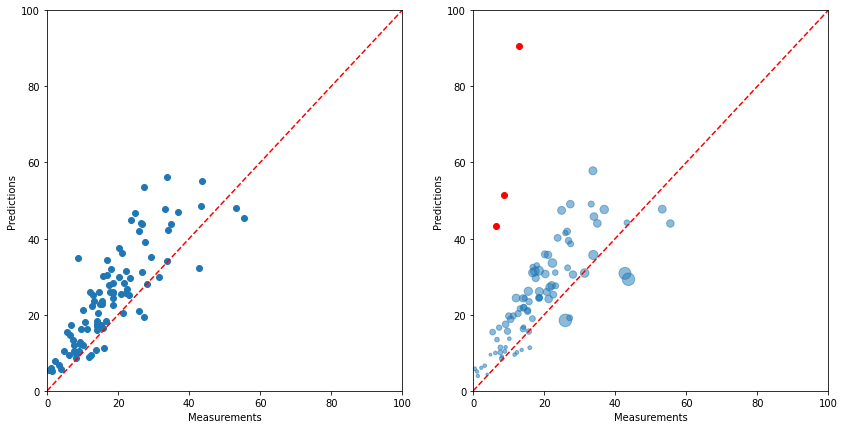

In [260]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(14,7))
ax.scatter(measurements, predictions)
ax.plot((0,100),(0,100), c="red", linestyle="dashed")
ax.set_xlabel("Measurements")
ax.set_ylabel("Predictions")
ax.set_xlim((0,100))
ax.set_ylim((0,100))

ax2.scatter(measurements[valid], predictions_dropout[valid], s=variances[valid]*5, alpha=0.5)
ax2.scatter(measurements[~valid], predictions_dropout[~valid], c="red")
ax2.plot((0,100),(0,100), c="red", linestyle="dashed")
ax2.set_xlabel("Measurements")
ax2.set_ylabel("Predictions")
ax2.set_xlim((0,100))
ax2.set_ylim((0,100))

plt.show()

In [26]:
data = np.stack([measurements, predictions])
data_dropout = np.stack([measurements, predictions_dropout])

In [28]:
if frequency == "2018_2020":
    frequency = "whole_timespan"

In [29]:
np.save("data_figures/test_S2S5P_" + frequency + "_epa.npy", data)

In [30]:
np.save("data_figures/test_S2S5P_" + frequency + "_dropout_epa.npy", data_dropout)

In [ ]:
np.isnan(predictions_dropout).all()

In [37]:
stations[~valid]

array([['06-065-5001'],
       ['32-003-0540'],
       ['32-003-0075'],
       ['06-111-3001'],
       ['06-071-1234']], dtype='<U11')

In [73]:
stations[variances < 3]

array([['06-019-4001'],
       ['06-113-0004'],
       ['06-067-0011'],
       ['06-031-1004'],
       ['06-083-1025'],
       ['06-029-0007'],
       ['06-077-3005'],
       ['06-083-1014'],
       ['06-047-0003'],
       ['06-023-1004'],
       ['06-039-0004'],
       ['06-079-4002'],
       ['06-083-1021'],
       ['06-065-1016']], dtype='<U11')

In [72]:
stations[ae < 0.7]

array([['06-037-9033'],
       ['32-003-0561'],
       ['06-079-8002'],
       ['06-023-1004']], dtype='<U11')

In [50]:
ae = np.abs(measurements - predictions_dropout)

In [51]:
stations[ae > 20]

array([['06-065-5001'],
       ['06-037-1302'],
       ['32-003-0540'],
       ['32-003-0075'],
       ['06-111-3001'],
       ['06-037-1103'],
       ['06-071-1234'],
       ['06-059-0007']], dtype='<U11')

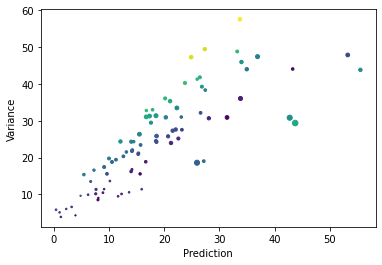

In [54]:
plt.scatter(measurements[valid], predictions_dropout[valid], s=variances[valid], c=ae[valid])
plt.xlabel("Prediction")
plt.ylabel("Variance")
plt.show()

# Visualize failure cases

In [177]:
low_var = variances < 2.35

In [178]:
stations[~valid].shape, low_var.sum()

((5, 1), 5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


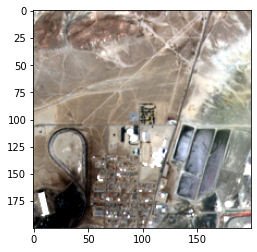

In [159]:
for station in stations[~valid]:
    img = np.load(glob.glob(os.path.join(datadir, "sentinel-2", station.item(), "*.npy"))[0])
    show(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


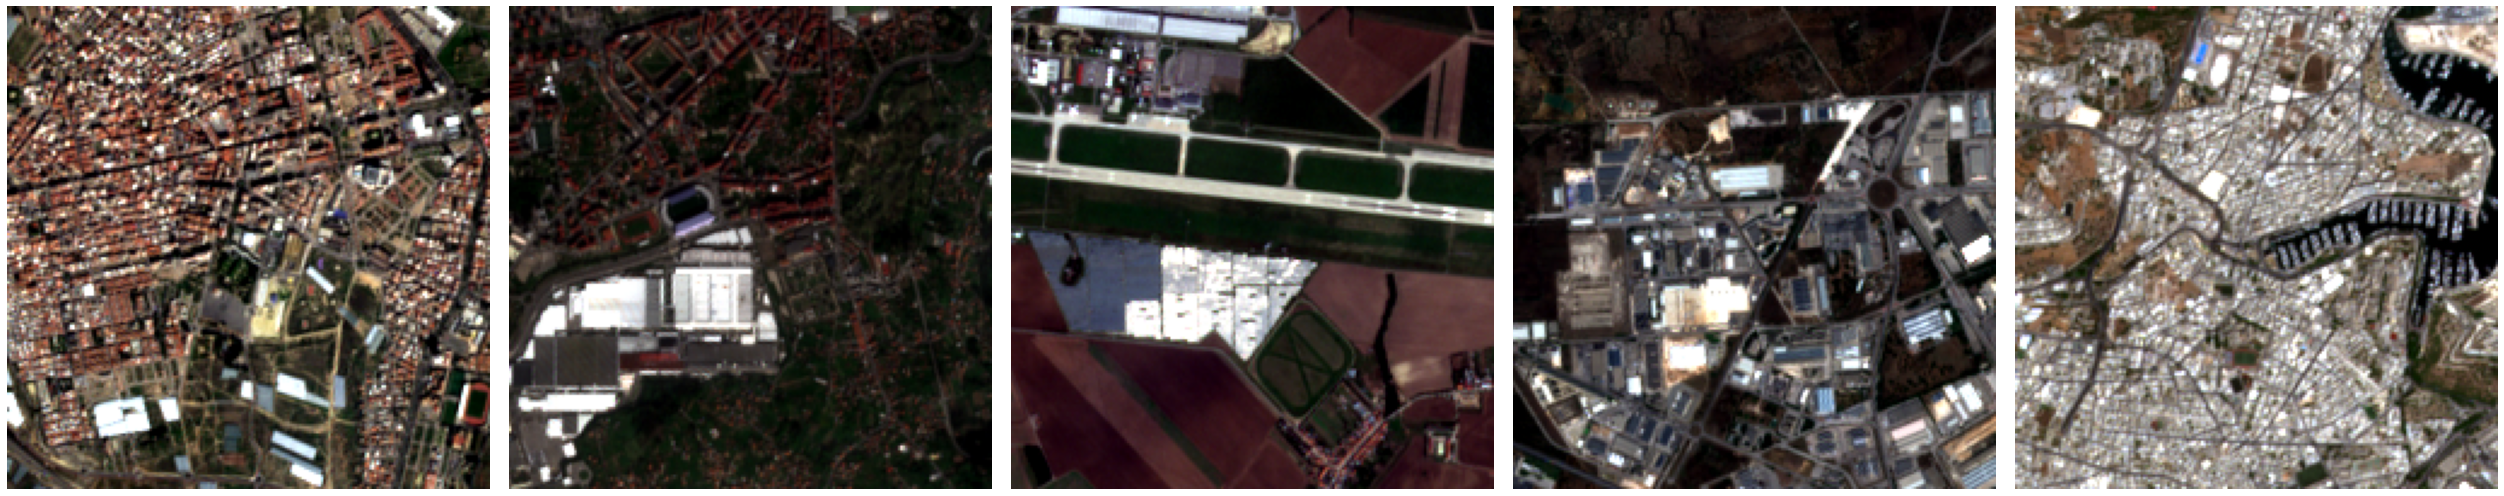

In [218]:
fig, axs = plt.subplots(1, 5, figsize=(35, 7))
for ax, station in zip(axs, stations[~valid]):
    img = np.load(glob.glob(os.path.join(datadir, "sentinel-2", station.item(), "*.npy"))[0])
    ax.imshow(normalized_rgb(img))
    ax.axis(False)
    
#for ax, station in zip(axs[1,:], np.random.choice(stations[valid].squeeze(), size=5)):
#    img = np.load(glob.glob(os.path.join(datadir, "sentinel-2", station.item(), "*.npy"))[0])
#    ax.imshow(normalized_rgb(img))
#    ax.axis(False)
    
#plt.show()
plt.tight_layout()
plt.savefig("figures/epa_high_variance_cases.pdf")

In [219]:
stations[valid].shape

(3061, 1)

In [226]:
inf_vals = variances == np.inf

# Compare Uncertainty RMS with model RMSE

In [241]:
unc_rms = ((variances[valid]**2).sum() / variances[valid].shape[0])**0.5

In [242]:
unc_rms, mean_squared_error(measurements, predictions_dropout)**0.5

(9.557778402566129, 13.629371901003685)

In [222]:
variances.max()

inf